# Data loading

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
FOLDER = "."

In [ ]:
import os
import random
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout, Input, Concatenate, Flatten, RepeatVector
)
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotUniform, Zeros
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

2024-11-23 19:14:36.594124: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 19:14:36.609463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732360476.625768 1798180 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732360476.630455 1798180 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 19:14:36.647344: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
import GPUtil

# Get the 4 GPUs with the most available memory (most of the time 4 cpu are free from UGCPU)
gpus = GPUtil.getAvailable(order='memory', limit=4)

# Set the selected GPUs to be visible
if len(gpus) >= 4:
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpus[0]},{gpus[1]},{gpus[2]},{gpus[3]}"
    print(f"Using GPUs: {gpus[0]}, {gpus[1]}, {gpus[2]}, {gpus[3]}")
else:
    print("Not enough available GPUs. Only found:", gpus)

visible_gpus = tf.config.list_physical_devices('GPU')
for gpu in visible_gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

print("Num GPUs Available after reset:", len(gpus))

Using GPUs: 5, 6, 7, 0
Num GPUs Available after reset: 4


In [5]:
# Load the train.csv file
train_data = pd.read_csv(f'{FOLDER}/shuffled_A_B_relation_train.csv')
train_data

,EventA,EventB,relation
0,PersonX causes trouble,"['Is arrested', 'Thrown in jail']",xEffect
1,PersonX drops off the radar,"['has peace an quiet', 'gets more sleep']",xEffect
2,PersonX starts the fire,"['to light a match', 'to pour gasoline everywh...",xNeed
3,PersonX attends to PersonY's duties,"['to hear thanks', 'keep helping person']",xWant
4,PersonX lets PersonY go,"['sad, but helpful']",xReact
...,...,...,...
319770,PersonX closes PersonY's doors,"['helpful', 'generous']",xReact
319771,PersonX has a pizza party,"['thank personx', 'help clean up']",oWant
319772,PersonX invites PersonY to PersonX's house,['like he made a friend'],xReact
319773,PersonX blows PersonY's nose,"['to protest', 'to thank PersonX']",oWant


Understand the data

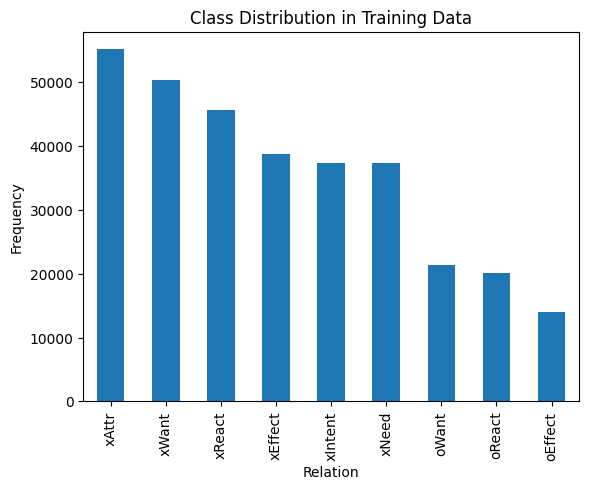

In [7]:
relation_counts = train_data['relation'].value_counts()
relation_counts.plot(kind='bar')
plt.xlabel('Relation')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Data')
plt.show()

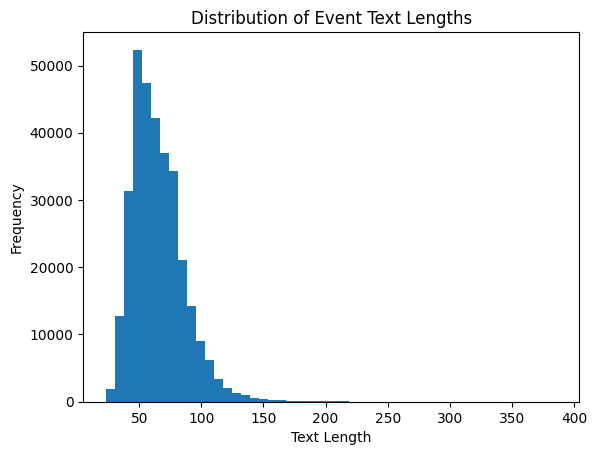

In [ ]:
# Check the distribution of text lengths for input events
train_data['text_length'] = train_data['EventA'].apply(len) + train_data['EventB'].apply(len)
train_data['text_length'].plot(kind='hist', bins=50)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Event Text Lengths')
plt.show()

In [9]:
train_data["relation"].unique()

array(['xEffect', 'xNeed', 'xWant', 'xReact', 'xAttr', 'xIntent',
       'oReact', 'oEffect', 'oWant'], dtype=object)

In [ ]:
# Step 1: Construct the relation vocabulary
relations = train_data['relation'].unique()
relation_vocab = {relation: idx for idx, relation in enumerate(relations)}
print("Relation Vocabulary:", relation_vocab)

Relation Vocabulary: {'xEffect': 0, 'xNeed': 1, 'xWant': 2, 'xReact': 3, 'xAttr': 4, 'xIntent': 5, 'oReact': 6, 'oEffect': 7, 'oWant': 8}


## Resampling (will not use)

SMOTE is not suitable for text data because the feature space of text data is not suitable for interpolation.

In [ ]:
# from imblearn.over_sampling import SMOTE

# train_features_np = preprocess_input(train_data, vocab)
# train_targets_np = train_data['relation'].map(relation_vocab).values

# smote = SMOTE()
# train_features_resampled, train_targets_resampled = smote.fit_resample(train_features_np, train_targets_np)

# # TensorFlow Dataset
# train_dataset_resampled = tf.data.Dataset.from_tensor_slices((train_features_resampled, train_targets_resampled))

In [12]:
# resampled_targets_series = pd.Series(train_targets_resampled)
# print(len(resampled_targets_series))

# # plot out the new resampled data
# resampled_targets_series.value_counts().plot(kind='bar')
# plt.xlabel('Class Label')
# plt.ylabel('Frequency')
# plt.title('Class Distribution after Resampling')
# plt.show()

In [13]:
# print(train_dataset_resampled)

# Data Augmentation

In [ ]:
import nltk
from nltk.corpus import wordnet

# Set the download directory for NLTK data
nltk.data.path.append(FOLDER)
# Download WordNet data
nltk.download('wordnet', download_dir=FOLDER)
nltk.download('omw-1.4', download_dir=FOLDER)

def synonym_replacement(sentence, n=2):
    words = sentence.split()
    new_words = words.copy()
    # Create a list of words that have synonyms in WordNet
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            # Get the first synonym
            synonym = synonyms[0].lemmas()[0].name() 
            if synonym != random_word:
                # Replace the word with its synonym
                new_words = [synonym if word == random_word else word for word in new_words]
                num_replaced += 1
            if num_replaced >= n:
                break
    return ' '.join(new_words)

[nltk_data] Downloading package wordnet to ....
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to ....
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
augmented_data = []

for _, row in train_data.iterrows():
    event_a = row['EventA']
    event_b = row['EventB']
    relation = row['relation']

    # Original data
    augmented_data.append({'EventA': event_a, 'EventB': event_b, 'relation': relation})

    # Perform data augmentation on EventA and EventB separately
    augmented_event_a = synonym_replacement(event_a)
    augmented_event_b = synonym_replacement(event_b)

    # Add augmented data
    augmented_data.append({'EventA': augmented_event_a, 'EventB': event_b, 'relation': relation})
    augmented_data.append({'EventA': event_a, 'EventB': augmented_event_b, 'relation': relation})
    augmented_data.append({'EventA': augmented_event_a, 'EventB': augmented_event_b, 'relation': relation})

augmented_df = pd.DataFrame(augmented_data)

In [ ]:
# Get all text
all_text = augmented_df['EventA'].tolist() + augmented_df['EventB'].tolist()

# Tokenize
all_tokens = []
for text in all_text:
    tokens = text.split()
    all_tokens.extend(tokens)

# Count word frequencies
token_counter = Counter(all_tokens)

# Create vocabulary
vocab = {word: idx + 1 for idx, (word, _) in enumerate(token_counter.items())}
vocab['<unk>'] = 0  # Unknown word
print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 85078


In [17]:
augmented_df.to_csv(f'{FOLDER}/augmented_data.csv', index=False)
augmented_df

,EventA,EventB,relation
0,PersonX causes trouble,"['Is arrested', 'Thrown in jail']",xEffect
1,PersonX cause trouble,"['Is arrested', 'Thrown in jail']",xEffect
2,PersonX causes trouble,"['Is arrested', 'Thrown inch jail']",xEffect
3,PersonX cause trouble,"['Is arrested', 'Thrown inch jail']",xEffect
4,PersonX drops off the radar,"['has peace an quiet', 'gets more sleep']",xEffect
...,...,...,...
1279095,PersonX blow PersonY's nose,"['to protest', 'to thank PersonX']",oWant
1279096,PersonX gives PersonY PersonX's attention,"['openminded', 'closer to persony']",xReact
1279097,PersonX give PersonY PersonX's attention,"['openminded', 'closer to persony']",xReact
1279098,PersonX gives PersonY PersonX's attention,"['openminded', 'closer to persony']",xReact


# Data Preprocessing

In [18]:
print("EventA:", augmented_df.iloc[0]['EventA'])
print("EventB:", augmented_df.iloc[0]['EventB'])

EventA: PersonX causes trouble
EventB: ['Is arrested', 'Thrown in jail']


we need to combine event a and event b into one event, and then use the combined event to train the model.

In [19]:
# remove []
augmented_df['EventB'] = augmented_df['EventB'].str.replace('[', '').str.replace(']', '')
# remove ' and ,
augmented_df['EventB'] = augmented_df['EventB'].str.replace("'", '').str.replace(',', '')
augmented_df.head()

,EventA,EventB,relation
0,PersonX causes trouble,Is arrested Thrown in jail,xEffect
1,PersonX cause trouble,Is arrested Thrown in jail,xEffect
2,PersonX causes trouble,Is arrested Thrown inch jail,xEffect
3,PersonX cause trouble,Is arrested Thrown inch jail,xEffect
4,PersonX drops off the radar,has peace an quiet gets more sleep,xEffect


manually remove the data with quote in the text.

In [20]:
# Combine EventA and EventB into one column and convert list of words in EventB to words
augmented_df['CombinedEventAB'] = augmented_df['EventA'] + " " + augmented_df['EventB']
augmented_df.head()

,EventA,EventB,relation,CombinedEventAB
0,PersonX causes trouble,Is arrested Thrown in jail,xEffect,PersonX causes trouble Is arrested Thrown in jail
1,PersonX cause trouble,Is arrested Thrown in jail,xEffect,PersonX cause trouble Is arrested Thrown in jail
2,PersonX causes trouble,Is arrested Thrown inch jail,xEffect,PersonX causes trouble Is arrested Thrown inch...
3,PersonX cause trouble,Is arrested Thrown inch jail,xEffect,PersonX cause trouble Is arrested Thrown inch ...
4,PersonX drops off the radar,has peace an quiet gets more sleep,xEffect,PersonX drops off the radar has peace an quiet...


In [21]:
augmented_df

,EventA,EventB,relation,CombinedEventAB
0,PersonX causes trouble,Is arrested Thrown in jail,xEffect,PersonX causes trouble Is arrested Thrown in jail
1,PersonX cause trouble,Is arrested Thrown in jail,xEffect,PersonX cause trouble Is arrested Thrown in jail
2,PersonX causes trouble,Is arrested Thrown inch jail,xEffect,PersonX causes trouble Is arrested Thrown inch...
3,PersonX cause trouble,Is arrested Thrown inch jail,xEffect,PersonX cause trouble Is arrested Thrown inch ...
4,PersonX drops off the radar,has peace an quiet gets more sleep,xEffect,PersonX drops off the radar has peace an quiet...
...,...,...,...,...
1279095,PersonX blow PersonY's nose,to protest to thank PersonX,oWant,PersonX blow PersonY's nose to protest to than...
1279096,PersonX gives PersonY PersonX's attention,openminded closer to persony,xReact,PersonX gives PersonY PersonX's attention open...
1279097,PersonX give PersonY PersonX's attention,openminded closer to persony,xReact,PersonX give PersonY PersonX's attention openm...
1279098,PersonX gives PersonY PersonX's attention,openminded closer to persony,xReact,PersonX gives PersonY PersonX's attention open...


# Data -> tf format

In [40]:
# Step 3: Prepare the dataset using TensorFlow
class AtomicDataset(tf.data.Dataset):
    def __new__(cls, dataframe, vocab, relation_vocab, max_length=30):
        # Convert the dataframe into sequences of indices
        original_features_list = []
        features_list = []
        targets_list = []

        for _, row in dataframe.iterrows():
            # Concatenate EventA and EventB as the input features
            original_features = row['CombinedEventAB'] # which is the combinedEventAB
            features = original_features 
            tokens = features.split()

            # Convert tokens to indices using vocab
            feature_indices = [vocab.get(word, 0) for word in tokens]  # Use 0 if word is not in vocab (<unk>)

            # Padding or trimming to ensure consistent length
            if len(feature_indices) > max_length:
                feature_indices = feature_indices[:max_length]  # Trim to max_length
            else:
                feature_indices += [0] * (max_length - len(feature_indices))  # Pad with zeros

            # Append features and target to the list
            original_features_list.append(original_features)
            features_list.append(feature_indices)
            targets_list.append(relation_vocab[row['relation']])

        # Convert lists to numpy arrays
        original_features_np = np.array(original_features_list, dtype=np.str_)
        features_np = np.array(features_list, dtype=np.int32)
        targets_np = np.array(targets_list, dtype=np.int32)

        # Create a TensorFlow dataset
        # return tf.data.Dataset.from_tensor_slices((original_features_np, features_np, targets_np)) # only used to check before training, not used anymore
        return tf.data.Dataset.from_tensor_slices((features_np, targets_np))

In [41]:
# Step 4: Create training and validation datasets
train_data_augmented, val_data_augmented = train_test_split(augmented_df, test_size=0.2, random_state=42)

# Create TensorFlow datasets from the augmented data
train_dataset = AtomicDataset(train_data_augmented, vocab, relation_vocab, max_length=30)
val_dataset = AtomicDataset(val_data_augmented, vocab, relation_vocab, max_length=30)

# Set batch size
batch_size = 512

# Shuffle and batch the training dataset, and prefetch for performance optimization
train_dataset = train_dataset.shuffle(buffer_size=len(train_data_augmented)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

testing dataset

In [42]:
# Check 1 sample from the dataset
# with original feature debugging is commented out as input dim is 2 but not 3
# for i, (original_features, features, target) in enumerate(train_dataset.take(1)):
    # original_features_decoded = [feat.decode('utf-8') if isinstance(feat, bytes) else feat for feat in original_features.numpy()]
    # print(f"Original Features (Index {i}): {' '.join(original_features_decoded)}")
    # print(f"Encoded Features (Index {i}): {features.numpy()}")
    # print(f"Target (Index {i}): {target.numpy()}")

for i, (features, target) in enumerate(train_dataset.take(1)):
    print(f"Features shape: {features.shape}")
    print(f"Target shape: {target.shape}")
    print(f"Features (Index {i}): {features.numpy()}")
    print(f"Target (Index {i}): {target.numpy()}")

Features shape: (512, 30)
Target shape: (512,)
Features (Index 0): [[   1 1103  104 ...    0    0    0]
 [   1   11 5067 ...    0    0    0]
 [   1   77   30 ...    0    0    0]
 ...
 [   1  641   36 ...    0    0    0]
 [   1 3059   16 ...    0    0    0]
 [   1  161   34 ...    0    0    0]]
Target (Index 0): [5 5 2 2 2 4 0 4 1 3 2 1 2 0 5 0 7 4 1 2 0 7 4 4 8 8 4 8 3 4 3 5 0 0 5 3 5
 0 8 4 5 6 0 3 2 2 3 3 3 0 2 2 6 1 5 1 3 5 5 3 2 3 0 2 0 2 1 0 2 6 6 2 8 0
 2 2 3 0 6 3 1 3 3 4 4 8 0 0 3 2 0 6 4 7 0 5 3 0 3 0 0 0 6 4 2 0 5 4 1 4 3
 2 2 6 2 0 3 3 0 3 8 2 4 5 4 6 3 3 0 4 2 5 5 7 1 4 4 7 4 2 2 3 4 1 7 1 6 0
 8 6 8 3 4 2 2 8 4 0 3 7 4 0 4 8 0 4 0 2 1 4 4 3 0 3 4 4 4 2 4 0 3 2 1 1 3
 1 7 2 0 1 3 0 4 6 4 2 2 4 3 8 2 3 3 8 1 6 3 0 4 7 4 1 8 2 1 4 8 1 6 1 1 0
 1 7 1 2 7 6 2 3 8 4 8 4 3 6 5 4 3 2 4 0 4 4 5 1 0 3 3 2 5 6 8 1 1 2 4 0 2
 6 1 3 1 0 3 3 4 2 2 4 4 3 3 3 3 1 4 4 5 7 1 2 4 5 4 4 0 5 8 6 3 5 2 8 3 4
 8 2 0 6 6 0 2 2 3 4 8 4 3 0 6 1 1 4 5 0 4 2 3 4 3 8 0 2 4 2 2 4 3 4 8 1 4
 5 1 1 5 0 0

# Training

In [ ]:
# Step 5: Define LSTM Model
vocab_size = len(vocab) + 1  # Add 1 to include <pad> or <unk> token
embedding_dim = 64           # Dimension of word embeddings
hidden_dim = 256             
output_dim = len(relation_vocab)  # Output dimension matches the number of relation classes

model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    layers.LSTM(hidden_dim, return_sequences=False, dropout=0.5),
    layers.BatchNormalization(), # enhanse convergense
    layers.Dense(256, activation='relu'), # Added an extra Dense layer]
    layers.Dropout(0.5),  # prevent overfitting
    layers.Dense(output_dim, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir='./logs')

# Step 6: Train the Model
epochs = 20  # Number of epochs for training

history = model.fit(
    train_dataset,
    validation_data=val_dataset, 
    epochs=epochs,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1  # Display progress bar
)

Epoch 1/20


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.5331 - loss: 1.2415 - val_accuracy: 0.6865 - val_loss: 0.8454
Epoch 2/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7057 - loss: 0.7915 - val_accuracy: 0.7329 - val_loss: 0.7033
Epoch 3/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7444 - loss: 0.6835 - val_accuracy: 0.7525 - val_loss: 0.6462
Epoch 4/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7620 - loss: 0.6334 - val_accuracy: 0.7645 - val_loss: 0.6222
Epoch 5/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7738 - loss: 0.6003 - val_accuracy: 0.7734 - val_loss: 0.5969
Epoch 6/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7838 - loss: 0.5723 - val_accuracy: 0.7779 - val_loss: 0.5832
Epoch 7/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7921 - loss: 0.5501 - val_accuracy: 0.7850 - val_loss: 0.5628
Epoch 8/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7970 - loss: 0.5339 - val

In [45]:
# Step 7: Save the trained model
model_save_path = f'{FOLDER}/trained_lstm_model_task1.h5'  # You can specify any path you like
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to ./trained_lstm_model_task1.h5


In [46]:
# from tensorflow.keras.models import load_model

# # Load the saved model
# loaded_model = load_model('trained_lstm_model.h5')

# Prediction

## Reusable code

In [47]:
augmented_df.head()

,EventA,EventB,relation,CombinedEventAB
0,PersonX causes trouble,Is arrested Thrown in jail,xEffect,PersonX causes trouble Is arrested Thrown in jail
1,PersonX cause trouble,Is arrested Thrown in jail,xEffect,PersonX cause trouble Is arrested Thrown in jail
2,PersonX causes trouble,Is arrested Thrown inch jail,xEffect,PersonX causes trouble Is arrested Thrown inch...
3,PersonX cause trouble,Is arrested Thrown inch jail,xEffect,PersonX cause trouble Is arrested Thrown inch ...
4,PersonX drops off the radar,has peace an quiet gets more sleep,xEffect,PersonX drops off the radar has peace an quiet...


In [48]:
def preprocess_input(df, vocab, max_length=30):
    features_list = []

    # Create TensorFlow datasets from the augmented data
    df_dataset = AtomicDataset(df, vocab, relation_vocab, max_length=30)

    # Set batch size
    batch_size = 512

    # Shuffle and batch the training dataset, and prefetch for performance optimization
    df_dataset = df_dataset.shuffle(buffer_size=len(train_data_augmented)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    return df_dataset

In [ ]:
def random_sample_prediction(df, model, vocab, relation_vocab, num_samples=5):
    for i in range(num_samples):
        # Step 1: Randomly select one data point from df
        random_index = random.randint(0, len(df) - 1)
        random_sample = df.iloc[random_index:random_index + 1]

        # Step 2: Preprocess the selected input using the function you defined earlier
        input_features_np = preprocess_input(random_sample, vocab)

        # Step 3: Get the correct output label for comparison
        correct_relation = random_sample['relation'].values[0]

        # Step 4: Make the prediction
        predictions = model.predict(input_features_np)

        # Step 5: Convert prediction to class label
        predicted_class = np.argmax(predictions, axis=-1)[0]  # Since it's only one input
        inverse_relation_vocab = {v: k for k, v in relation_vocab.items()}
        predicted_label = inverse_relation_vocab[predicted_class]

        # Step 6: Display the input, correct output, and predicted output
        print("Input Features:", random_sample['CombinedEventAB'].values[0])
        print("Correct Output:", correct_relation)
        print("LSTM Predicted:", predicted_label)

        # Step 7: Generate a list of top predictions for all labels
        top_n = 9  # i want all the labels to be shown
        top_n_indices = np.argsort(predictions[0])[-top_n:][::-1]
        top_n_labels = [inverse_relation_vocab[idx] for idx in top_n_indices]
        top_n_probs = [predictions[0][idx] for idx in top_n_indices]

        print("Top N Predictions:")
        for label, prob in zip(top_n_labels, top_n_probs):
            print(f"{label}: {prob:.3f}", end=', ')
        print("\n")

In [ ]:
def plot_confusion_matrix(model, val_dataset, relation_vocab):
    # Step 1: Make predictions on the validation dataset
    val_features = []
    val_labels = []

    for features, label in val_dataset:
        val_features.append(features.numpy())
        val_labels.append(label.numpy())

    # Convert lists to numpy arrays
    val_features_np = np.concatenate(val_features, axis=0)
    val_labels_np = np.concatenate(val_labels, axis=0)

    # Get predictions
    predictions = model.predict(val_features_np)
    predicted_labels = np.argmax(predictions, axis=-1)

    # Step 2: Generate confusion matrix
    cm = confusion_matrix(val_labels_np, predicted_labels)

    # Step 3: Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(relation_vocab.keys()))
    disp.plot(cmap=plt.cm.Blues)

    # Show the confusion matrix
    fig = disp.figure_
    fig.set_size_inches(10, 10)  # Adjust the size of the plot
    plt.show()

    # Get the number of classes
    num_classes = cm.shape[0]

    # Initialize Precision and Recall lists
    precision = []
    recall = []

    # Calculate Precision and Recall for each class
    for i in range(num_classes):
        TP = cm[i, i]  # Diagonal element
        FP = np.sum(cm[:, i]) - TP  # Sum of the column minus TP
        FN = np.sum(cm[i, :]) - TP  # Sum of the row minus TP

        precision_i = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall_i = TP / (TP + FN) if (TP + FN) > 0 else 0

        precision.append(precision_i)
        recall.append(recall_i)

    # Convert to percentages and print results
    precision_percent = [f"{p * 100:.2f}%" for p in precision]
    recall_percent = [f"{r * 100:.2f}%" for r in recall]

    # Print Precision and Recall for each class
    accuracy = accuracy_score(val_labels_np, predicted_labels)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")
    for i, label in enumerate(relation_vocab):
        print(f"{label}: Precision = {precision_percent[i]}, Recall = {recall_percent[i]}")


## Predict on validation set

In [77]:
random_sample_prediction(val_data_augmented, model, vocab, relation_vocab, num_samples=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Input Features: PersonX discovery PersonX's voice happygrateful
Correct Output: oReact
LSTM Predicted: xAttr
Top N Predictions:
xAttr: 0.519, xReact: 0.436, oReact: 0.023, xIntent: 0.008, xEffect: 0.007, xWant: 0.003, oEffect: 0.002, xNeed: 0.002, oWant: 0.001, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Input Features: PersonX go every year keep a schedule prepare plan ahead
Correct Output: xNeed
LSTM Predicted: xNeed
Top N Predictions:
xNeed: 0.970, xWant: 0.030, oWant: 0.000, xEffect: 0.000, xIntent: 0.000, oEffect: 0.000, xReact: 0.000, oReact: 0.000, xAttr: 0.000, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Input Features: PersonX eventually found ___ to retrieve something to use something
Correct Output: xWant
LSTM Predicted: xWant
Top N Predictions:
xWant: 0.848, xIntent: 0.095, xNeed: 0.051, oWant: 0.005, xEffect: 0.000, xReact: 0.000, xAttr: 0.000, oReact: 0.000, oEffect: 0.000, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Input Features: PersonX wage PersonY tax PersonX is thanked PersonX receives a receipt
Correct Output: xEffect
LSTM Predicted: xEffect
Top N Predictions:
xEffect: 1.000, oEffect: 0.000, xWant: 0.000, xNeed: 0.000, xReact: 0.000, xAttr: 0.000, xIntent: 0.000, oWant: 0.000, oReact: 0.000, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Input Features: PersonX better PersonY's 

7995/7995 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


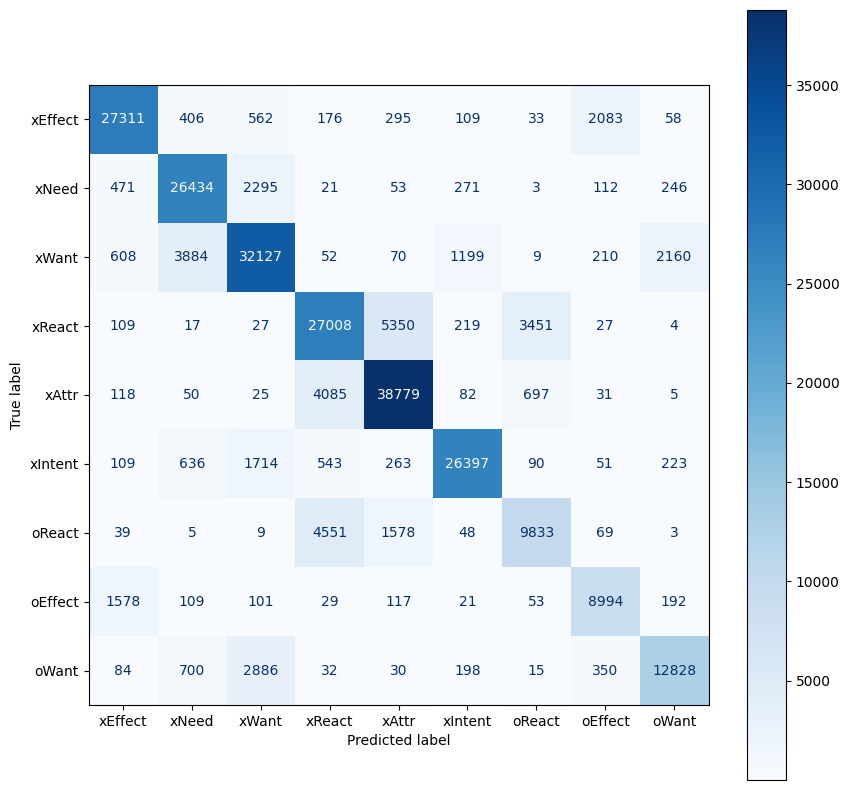

Overall Accuracy: 81.98%
xEffect: Precision = 89.76%, Recall = 88.01%
xNeed: Precision = 81.99%, Recall = 88.39%
xWant: Precision = 80.83%, Recall = 79.68%
xReact: Precision = 74.00%, Recall = 74.58%
xAttr: Precision = 83.33%, Recall = 88.39%
xIntent: Precision = 92.48%, Recall = 87.91%
oReact: Precision = 69.32%, Recall = 60.94%
oEffect: Precision = 75.41%, Recall = 80.35%
oWant: Precision = 81.61%, Recall = 74.92%


In [60]:
# Call the function
plot_confusion_matrix(model, val_dataset, relation_vocab)

# Predict on dataset generated by GPT-task-2

In [85]:
gpt_df = pd.read_csv(f'{FOLDER}/task2_zero-shot_cot_False.csv', index_col=0)
gpt_df.rename(columns={'predict': 'CombinedEventAB'}, inplace=True)
gpt_df.reset_index(drop=True, inplace=True)
gpt_df

,CombinedEventAB,relation
0,PersonX lets go of the tiger's tail.,xReact
1,PersonX takes up PersonY's cross to help PersonY.,xWant
2,PersonX pays PersonY tax == PersonY rewards Pe...,xAttr
3,PersonX feels satisfied after learning valuabl...,xWant
4,PersonX goes skydiving.,xAttr
...,...,...
3995,PersonX starts digging the ground with a shovel.,xAttr
3996,PersonY may reciprocate the attracted feelings...,oWant
3997,PersonX moves out.,oWant
3998,PersonX organizes a game night.,xAttr


check df integrity (generated by GPT, we cant garuntee the quality of the data)

In [86]:
# Check for NaN values in gpt_df
nan_counts = gpt_df.isnull().sum()
print("NaN values in each column:")
print(nan_counts)

# Optionally, you can handle NaN values, for example by dropping rows with NaN values
gpt_df = gpt_df.dropna()
print("NaN values have been dropped.")
gpt_df

NaN values in each column:
CombinedEventAB    9
relation           0
dtype: int64
NaN values have been dropped.


,CombinedEventAB,relation
0,PersonX lets go of the tiger's tail.,xReact
1,PersonX takes up PersonY's cross to help PersonY.,xWant
2,PersonX pays PersonY tax == PersonY rewards Pe...,xAttr
3,PersonX feels satisfied after learning valuabl...,xWant
4,PersonX goes skydiving.,xAttr
...,...,...
3995,PersonX starts digging the ground with a shovel.,xAttr
3996,PersonY may reciprocate the attracted feelings...,oWant
3997,PersonX moves out.,oWant
3998,PersonX organizes a game night.,xAttr


In [87]:
# check if the relation is in the relation_vocab
print(relation_vocab)
gpt_df = gpt_df[gpt_df['relation'].isin(relation_vocab.keys())]
gpt_df

{'xEffect': 0, 'xNeed': 1, 'xWant': 2, 'xReact': 3, 'xAttr': 4, 'xIntent': 5, 'oReact': 6, 'oEffect': 7, 'oWant': 8}


,CombinedEventAB,relation
0,PersonX lets go of the tiger's tail.,xReact
1,PersonX takes up PersonY's cross to help PersonY.,xWant
2,PersonX pays PersonY tax == PersonY rewards Pe...,xAttr
3,PersonX feels satisfied after learning valuabl...,xWant
4,PersonX goes skydiving.,xAttr
...,...,...
3995,PersonX starts digging the ground with a shovel.,xAttr
3996,PersonY may reciprocate the attracted feelings...,oWant
3997,PersonX moves out.,oWant
3998,PersonX organizes a game night.,xAttr


In [88]:
random_sample_prediction(gpt_df, model, vocab, relation_vocab, num_samples=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Input Features: PersonX adopts the cat.
Correct Output: xNeed
LSTM Predicted: xAttr
Top N Predictions:
xAttr: 0.579, xReact: 0.304, oReact: 0.098, xEffect: 0.008, oEffect: 0.005, xIntent: 0.004, xWant: 0.002, xNeed: 0.001, oWant: 0.001, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Input Features: PersonX receives a pay rise.
Correct Output: xNeed
LSTM Predicted: xAttr
Top N Predictions:
xAttr: 0.630, xReact: 0.296, oReact: 0.051, xEffect: 0.010, oEffect: 0.004, xIntent: 0.003, xWant: 0.003, xNeed: 0.001, oWant: 0.001, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Input Features: to wear the new shoes
Correct Output: xIntent
LSTM Predicted: xIntent
Top N Predictions:
xIntent: 0.906, xNeed: 0.064, xWant: 0.015, xReact: 0.007, xEffect: 0.005, oWant: 0.002, oReact: 0.001, xAttr: 0.001, oEffect: 0.001, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Input Features: PersonX finds the right page.
Correct Output: xNeed
LSTM Predicted: xReact
Top N Predictions:
xReact: 0.454, xAttr: 0.436, oReact: 0.096, xIntent: 0.004, xEffect: 0.004, oEffect: 0.003, xWant: 0.002, xNeed: 0.001, oWant: 0.001, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Input Features: PersonY asks for more details.
Correct Output: oEffect
LSTM Predicted: xEffect
Top N Predictions:
xEffect: 0.241, xReact: 0.208, xAttr: 0.1

 84/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2024-11-23 21:32:08.146581: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


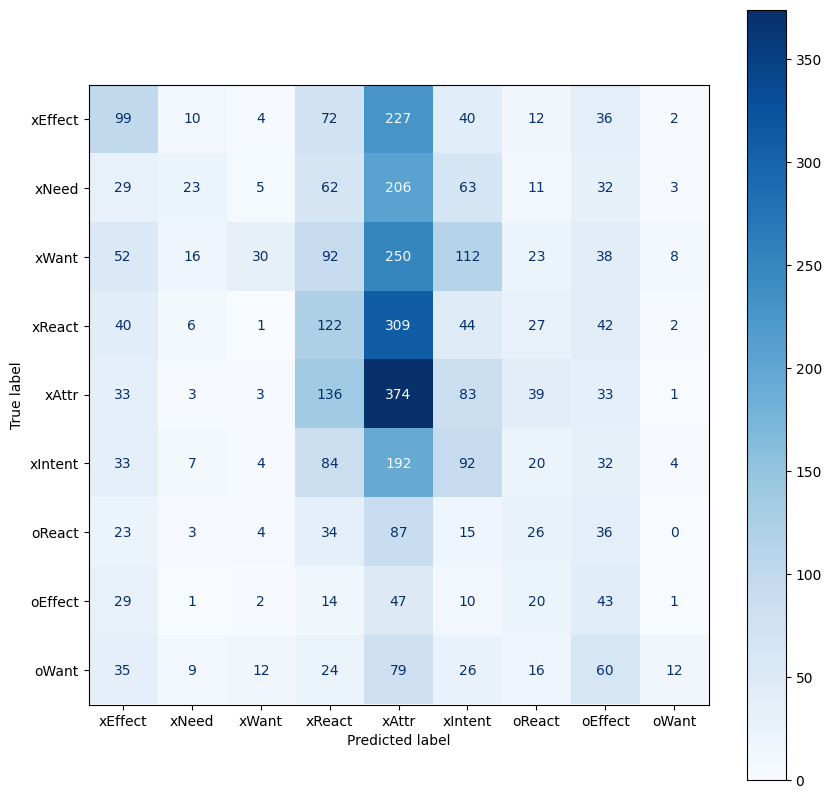

Overall Accuracy: 20.57%
xEffect: Precision = 26.54%, Recall = 19.72%
xNeed: Precision = 29.49%, Recall = 5.30%
xWant: Precision = 46.15%, Recall = 4.83%
xReact: Precision = 19.06%, Recall = 20.57%
xAttr: Precision = 21.12%, Recall = 53.05%
xIntent: Precision = 18.97%, Recall = 19.66%
oReact: Precision = 13.40%, Recall = 11.40%
oEffect: Precision = 12.22%, Recall = 25.75%
oWant: Precision = 36.36%, Recall = 4.40%


In [89]:
gpt_dataset = preprocess_input(gpt_df, vocab)
plot_confusion_matrix(model, gpt_dataset, relation_vocab)

In [90]:
def generate_predictions(df, model, vocab, relation_vocab, top_n=9):
    # Preprocess the input dataframe
    input_dataset = preprocess_input(gpt_df, vocab)

    # Make predictions
    predictions = model.predict(input_dataset)

    # Convert predictions to class labels
    inverse_relation_vocab = {v: k for k, v in relation_vocab.items()}
    top_n_predictions = []

    for pred in predictions:
        top_n_indices = np.argsort(pred)[-top_n:][::-1]
        top_n_labels = [inverse_relation_vocab[idx] for idx in top_n_indices]
        top_n_probs = [pred[idx] for idx in top_n_indices]
        top_n_predictions.append(list(zip(top_n_labels, top_n_probs)))

    # Add predictions to the dataframe
    df['top_n_predictions'] = top_n_predictions

    return df

# Generate predictions for 5 random samples from gpt_df
gpt_df_with_predictions = generate_predictions(gpt_df, model, vocab, relation_vocab, top_n=9)
gpt_df_with_predictions

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,CombinedEventAB,relation,top_n_predictions
0,PersonX lets go of the tiger's tail.,xReact,"[(oEffect, 0.982094), (xEffect, 0.014931834), ..."
1,PersonX takes up PersonY's cross to help PersonY.,xWant,"[(xReact, 0.447645), (oReact, 0.333279), (xAtt..."
2,PersonX pays PersonY tax == PersonY rewards Pe...,xAttr,"[(oWant, 0.48888212), (xWant, 0.3740197), (xIn..."
3,PersonX feels satisfied after learning valuabl...,xWant,"[(xReact, 0.45415008), (xAttr, 0.3884003), (oR..."
4,PersonX goes skydiving.,xAttr,"[(xIntent, 0.70232004), (xReact, 0.25249156), ..."
...,...,...,...
3995,PersonX starts digging the ground with a shovel.,xAttr,"[(xReact, 0.874523), (oReact, 0.06328528), (xA..."
3996,PersonY may reciprocate the attracted feelings...,oWant,"[(xEffect, 0.42176437), (oEffect, 0.30977806),..."
3997,PersonX moves out.,oWant,"[(xEffect, 0.5997882), (xWant, 0.36844632), (o..."
3998,PersonX organizes a game night.,xAttr,"[(xAttr, 0.8707763), (xReact, 0.12279627), (oR..."


In [91]:
# Save the prediction DataFrame to a CSV file
gpt_df_with_predictions.to_csv(f'{FOLDER}/gpt_predictions.csv', index=False)

print(f"Predictions saved to {FOLDER}/gpt_predictions.csv")

Predictions saved to ./gpt_predictions.csv
